In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\final_load_weather_data.csv")
df.head()


,ds,y,forecast_load,Unnamed: 0,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 01:00:00+00:00,26118.0,25385.0,11075,2015-01-01 02:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+00:00,26118.0,25385.0,63228,2015-01-01 02:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
2,2015-01-01 01:00:00+00:00,26118.0,25385.0,116333,2015-01-01 02:00:00,3128026,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800
3,2015-01-01 01:00:00+00:00,26118.0,25385.0,169280,2015-01-01 02:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
4,2015-01-01 01:00:00+00:00,26118.0,25385.0,221705,2015-01-01 02:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800



🔹 Training model for City ID: 2509954
✅ RMSE: 313.50 | R²: 0.995


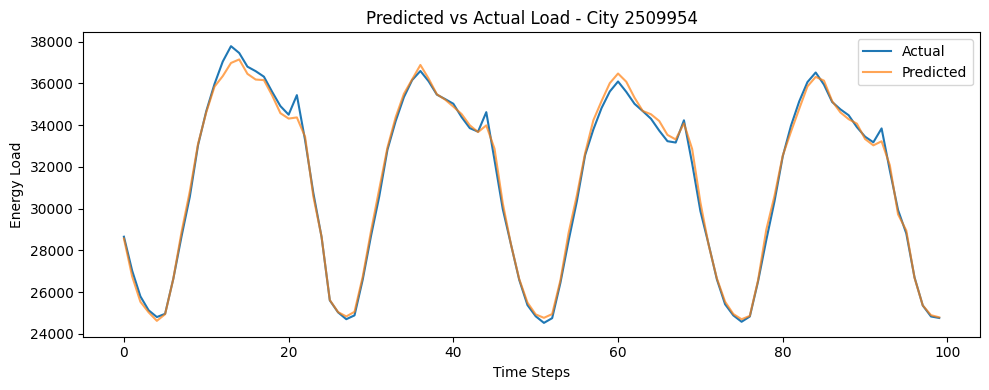


🔹 Training model for City ID: 3117735
✅ RMSE: 316.70 | R²: 0.995


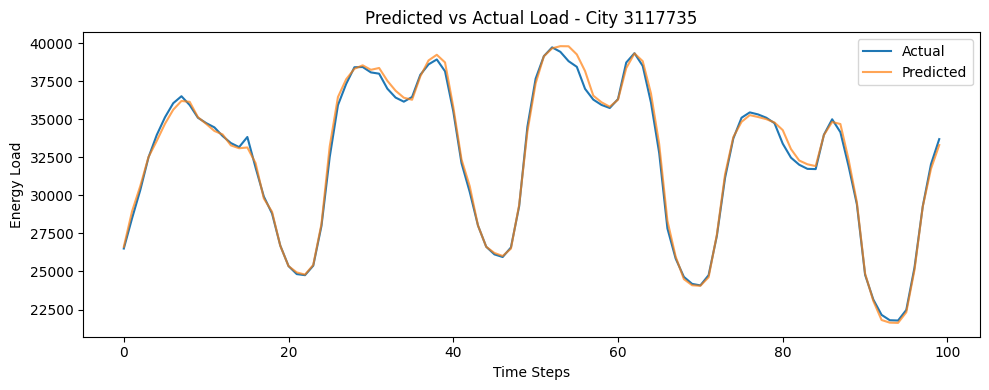


🔹 Training model for City ID: 3128026
✅ RMSE: 314.83 | R²: 0.995


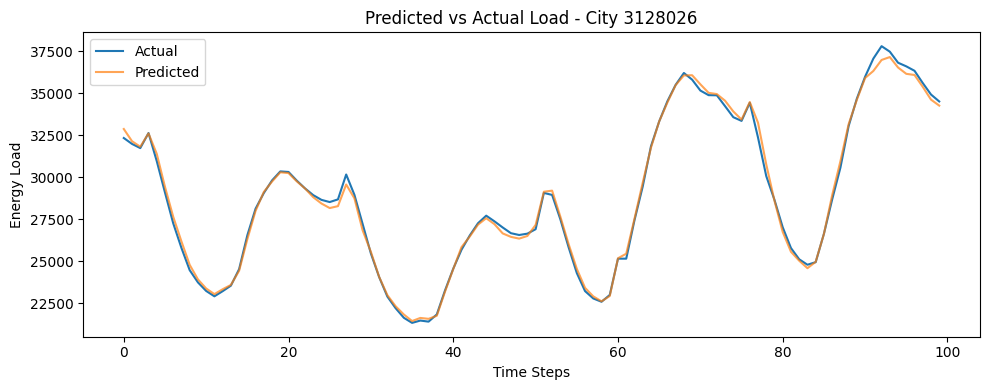


🔹 Training model for City ID: 3128760
✅ RMSE: 313.89 | R²: 0.995


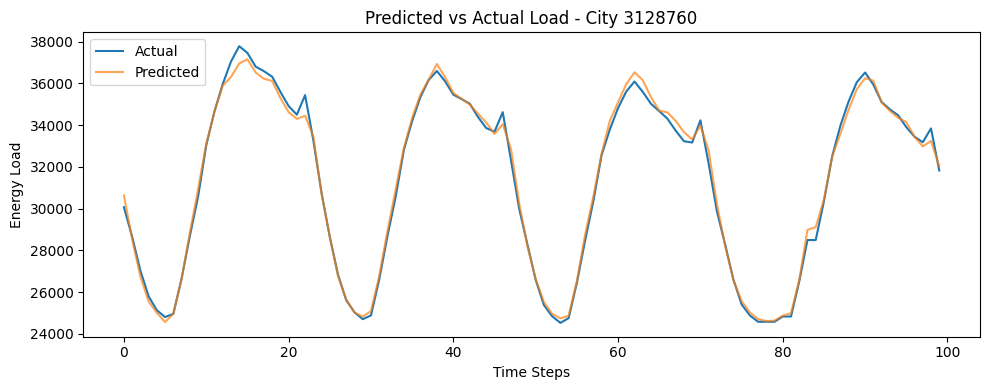


🔹 Training model for City ID: 6361046
✅ RMSE: 312.45 | R²: 0.995


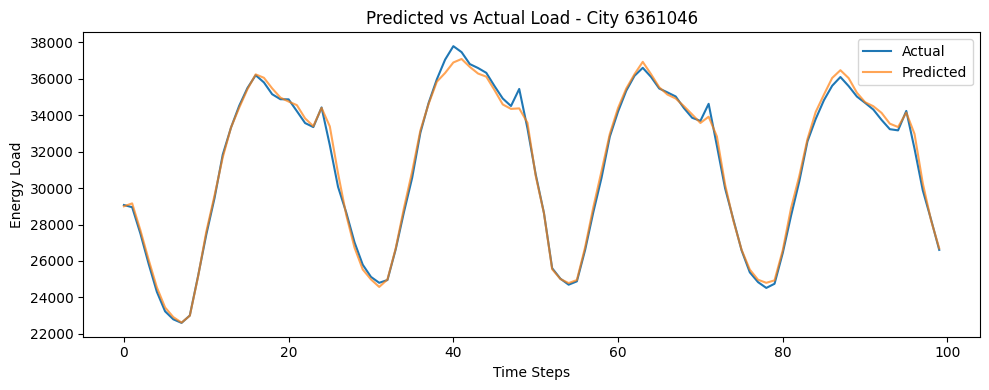

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Preprocess
df_xgb = df.copy()
df_xgb['ds'] = pd.to_datetime(df_xgb['ds'])
df_xgb = df_xgb.sort_values(by=['city_id', 'ds'])

# Step 2: Create Lag Features per City
lag_features = ['y']
for lag in [1, 2, 3]:
    df_xgb[f'lag_{lag}'] = df_xgb.groupby('city_id')['y'].shift(lag)

# Step 3: Add Rolling Feature
df_xgb['rolling_mean_3'] = df_xgb.groupby('city_id')['y'].shift(1).rolling(3).mean().reset_index(level=0, drop=True)

# Step 4: Drop rows with NaNs from lagging
df_xgb = df_xgb.dropna()

# Step 5: Drop non-useful columns
df_xgb = df_xgb.drop(columns=['Unnamed: 0', 'ds', 'dt'])

# Step 6: Train and Evaluate per City
results = {}
for city in df_xgb['city_id'].unique():
    print(f"\n🔹 Training model for City ID: {city}")
    
    city_df = df_xgb[df_xgb['city_id'] == city].copy()
    X = city_df.drop(columns=['y', 'city_id'])  # drop target + city ID
    y = city_df['y']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Model
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"✅ RMSE: {rmse:.2f} | R²: {r2:.3f}")
    
    results[city] = {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'rmse': rmse,
        'r2': r2,
        'features': X.columns
    }

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
    plt.title(f"Predicted vs Actual Load - City {city}")
    plt.ylabel("Energy Load")
    plt.xlabel("Time Steps")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
# We'll add the predicted values from XGBoost back to your DataFrame
df_optimized = df_xgb.copy()  # df_xgb has lag features and model input
df_optimized['predicted_y'] = np.nan

for city in df_optimized['city_id'].unique():
    city_rows = df_optimized['city_id'] == city
    X = df_optimized[city_rows].drop(columns=['y', 'city_id', 'predicted_y'])

    preds = results[city]['model'].predict(X)
    df_optimized.loc[city_rows, 'predicted_y'] = preds


In [5]:
df_optimized['error_model'] = df_optimized['y'] - df_optimized['predicted_y']
df_optimized['error_baseline'] = df_optimized['y'] - df_optimized['forecast_load']
df_optimized['model_better'] = abs(df_optimized['error_model']) < abs(df_optimized['error_baseline'])


In [6]:
high_deviation = df_optimized[
    (df_optimized['model_better'] == False) & 
    (abs(df_optimized['error_model']) > 1000)  # Adjust threshold
]

# View top problem rows
print(high_deviation[['city_id', 'y', 'forecast_load', 'predicted_y', 'error_model']].head())


      city_id        y  forecast_load   predicted_y  error_model
210   2509954  30136.0        29045.0  28995.796875  1140.203125
543   2509954  20654.0        21888.0  22056.080078 -1402.080078
2941  2509954  30583.0        29363.0  29211.857422  1371.142578
5170  2509954  37496.0        36464.0  36272.449219  1223.550781
5406  2509954  31138.0        29896.0  29806.484375  1331.515625


In [8]:
def simulate_scenario(model, sample_row, feature_changes, feature_order):
    modified = sample_row.copy()
    
    for feature, new_value in feature_changes.items():
        modified[feature] = new_value
    
    # Ensure we use the exact feature order the model was trained with
    modified = modified[feature_order]
    
    return model.predict(modified.values.reshape(1, -1))[0]

# Example: Simulate for one city
city = 2509954
model = results[city]['model']
features = results[city]['features']  # exact feature order used in training

# Grab a clean sample
sample = df_optimized[df_optimized['city_id'] == city][features].iloc[0]

# Simulate: What if humidity = 90?
predicted_with_high_humidity = simulate_scenario(model, sample, {'humidity': 90}, features)
print("Load with high humidity:", predicted_with_high_humidity)


Load with high humidity: 21939.393


In [9]:
simulate_scenario(model, sample, {'humidity': 10}, features)
simulate_scenario(model, sample, {'temp': 280, 'wind_speed': 5}, features)


21915.43

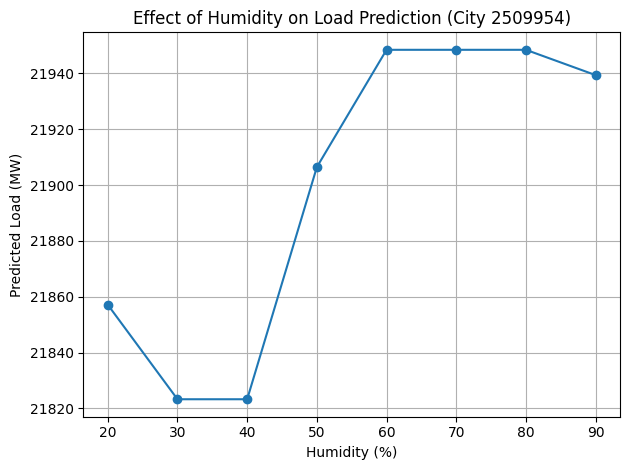

In [10]:
import matplotlib.pyplot as plt

# Simulate load under a range of humidity values
humidity_values = list(range(20, 100, 10))
predicted_loads = [
    simulate_scenario(model, sample, {'humidity': h}, features)
    for h in humidity_values
]

plt.plot(humidity_values, predicted_loads, marker='o')
plt.title("Effect of Humidity on Load Prediction (City 2509954)")
plt.xlabel("Humidity (%)")
plt.ylabel("Predicted Load (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import joblib
joblib.dump(results, "xgb_model_results.pkl")
df_optimized.to_csv("df_optimized.csv", index=False)


2025-06-19 20:24:07.167 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 20:24:07.168 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-19 20:24:07.172 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-19 20:24:07.174 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 20:24:07.613 
  command:

    streamlit run c:\Users\ASUS\OneDrive\Desktop\New folder\.venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-19 20:24:07.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 20:24:07.615 Thread 'MainThread': missing ScriptRunContext! This warning can b

DeltaGenerator()

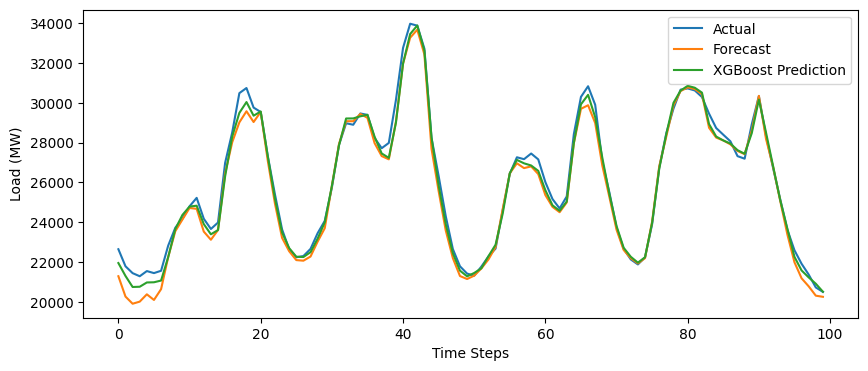

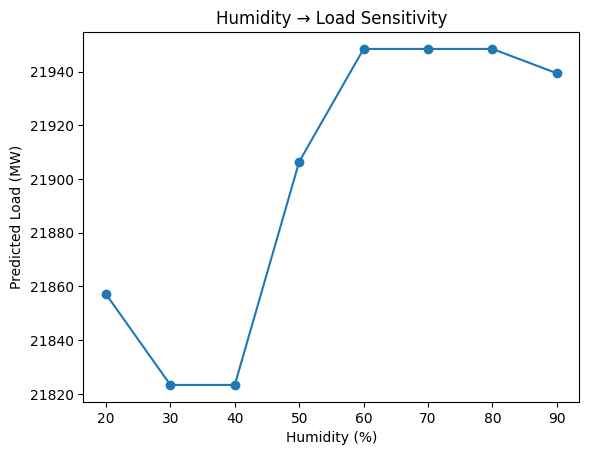

In [12]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

st.set_page_config(layout="wide")

# === LOAD DATA AND MODELS ===
@st.cache_data
def load_data():
    df = pd.read_csv("df_optimized.csv")  # should contain y, forecast_load, predicted_y, city_id, weather features
    results = joblib.load("xgb_model_results.pkl")  # { city_id: {model, features} }
    return df, results

df, results = load_data()

st.title("🔋 Renewable Energy Load Forecasting & Optimization")
city_ids = df['city_id'].unique()
selected_city = st.selectbox("Select City ID", city_ids)

city_df = df[df['city_id'] == selected_city].copy()
features = results[selected_city]['features']
model = results[selected_city]['model']

st.subheader(f"📈 Actual vs Forecast vs XGBoost - City {selected_city}")
plot_len = st.slider("Select number of time steps to display", 50, 500, 100)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(city_df['y'].values[:plot_len], label="Actual")
ax.plot(city_df['forecast_load'].values[:plot_len], label="Forecast")
ax.plot(city_df['predicted_y'].values[:plot_len], label="XGBoost Prediction")
ax.set_ylabel("Load (MW)")
ax.set_xlabel("Time Steps")
ax.legend()
st.pyplot(fig)

# === SIMULATION PANEL ===
st.subheader("⚙️ Optimization Simulation Panel")

# Pick a sample row to modify
sample = city_df[features].iloc[0].copy()

mod_features = {}
cols = st.columns(3)

for i, feat in enumerate(features):
    if np.issubdtype(city_df[feat].dtype, np.number):
        with cols[i % 3]:
            default = float(sample[feat])
            mod_features[feat] = st.slider(f"{feat}", float(default - 20), float(default + 20), float(default))

# Update sample and predict
for k, v in mod_features.items():
    sample[k] = v
sample = sample[features]
predicted = model.predict(sample.values.reshape(1, -1))[0]

st.success(f"🔮 Predicted Load under new conditions: **{predicted:.2f} MW**")

# === HUMIDITY IMPACT PLOT ===
st.subheader("📊 Impact of Humidity on Load (Simulation)")

humidity_range = list(range(20, 100, 10))
humid_loads = []

for h in humidity_range:
    temp_sample = sample.copy()
    if 'humidity' in features:
        temp_sample['humidity'] = h
    humid_loads.append(model.predict(temp_sample.values.reshape(1, -1))[0])

fig2, ax2 = plt.subplots()
ax2.plot(humidity_range, humid_loads, marker='o')
ax2.set_xlabel("Humidity (%)")
ax2.set_ylabel("Predicted Load (MW)")
ax2.set_title("Humidity → Load Sensitivity")
st.pyplot(fig2)
